In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Tengai.dataset import AirQuality
from Tengai.preprocessing import clustering_data,detect_outlier_zscore,detect_pdq_different
from Tengai.visual_series import (lineplot_features,lineplot_resample_feature,
                                  average_generating_barplot,visualize_adfuller_results,
                                  plotting_different)
import statsmodels.api as sm
from Tengai.model import grangers_causation_matrix,custom_train_test_split,ARITMA

## Load Data

In [2]:
data = AirQuality(-8.2325,114.3576)
data

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01 00:00:00,38.5,26.7,716.0,9.6,47.0,0.36,0.0
1,2023-01-01 01:00:00,31.1,21.4,624.0,7.8,60.0,0.34,0.0
2,2023-01-01 02:00:00,26.3,17.9,492.0,5.2,79.0,0.31,0.0
3,2023-01-01 03:00:00,24.2,16.4,347.0,2.5,98.0,0.29,0.0
4,2023-01-01 04:00:00,23.1,15.7,295.0,1.5,102.0,0.32,0.0
...,...,...,...,...,...,...,...,...
7219,2023-10-28 19:00:00,17.5,11.9,357.0,5.9,26.0,0.24,0.0
7220,2023-10-28 20:00:00,18.2,12.4,347.0,5.5,24.0,0.25,0.0
7221,2023-10-28 21:00:00,18.5,12.6,330.0,5.0,26.0,0.26,0.0
7222,2023-10-28 22:00:00,18.8,12.8,296.0,4.3,34.0,0.26,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7224 entries, 0 to 7223
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time                   7224 non-null   datetime64[ns]
 1   pm10                   7224 non-null   float64       
 2   pm2_5                  7224 non-null   float64       
 3   carbon_monoxide        7224 non-null   float64       
 4   nitrogen_dioxide       7224 non-null   float64       
 5   ozone                  7224 non-null   float64       
 6   aerosol_optical_depth  7224 non-null   float64       
 7   dust                   7224 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 451.6 KB


# EDA

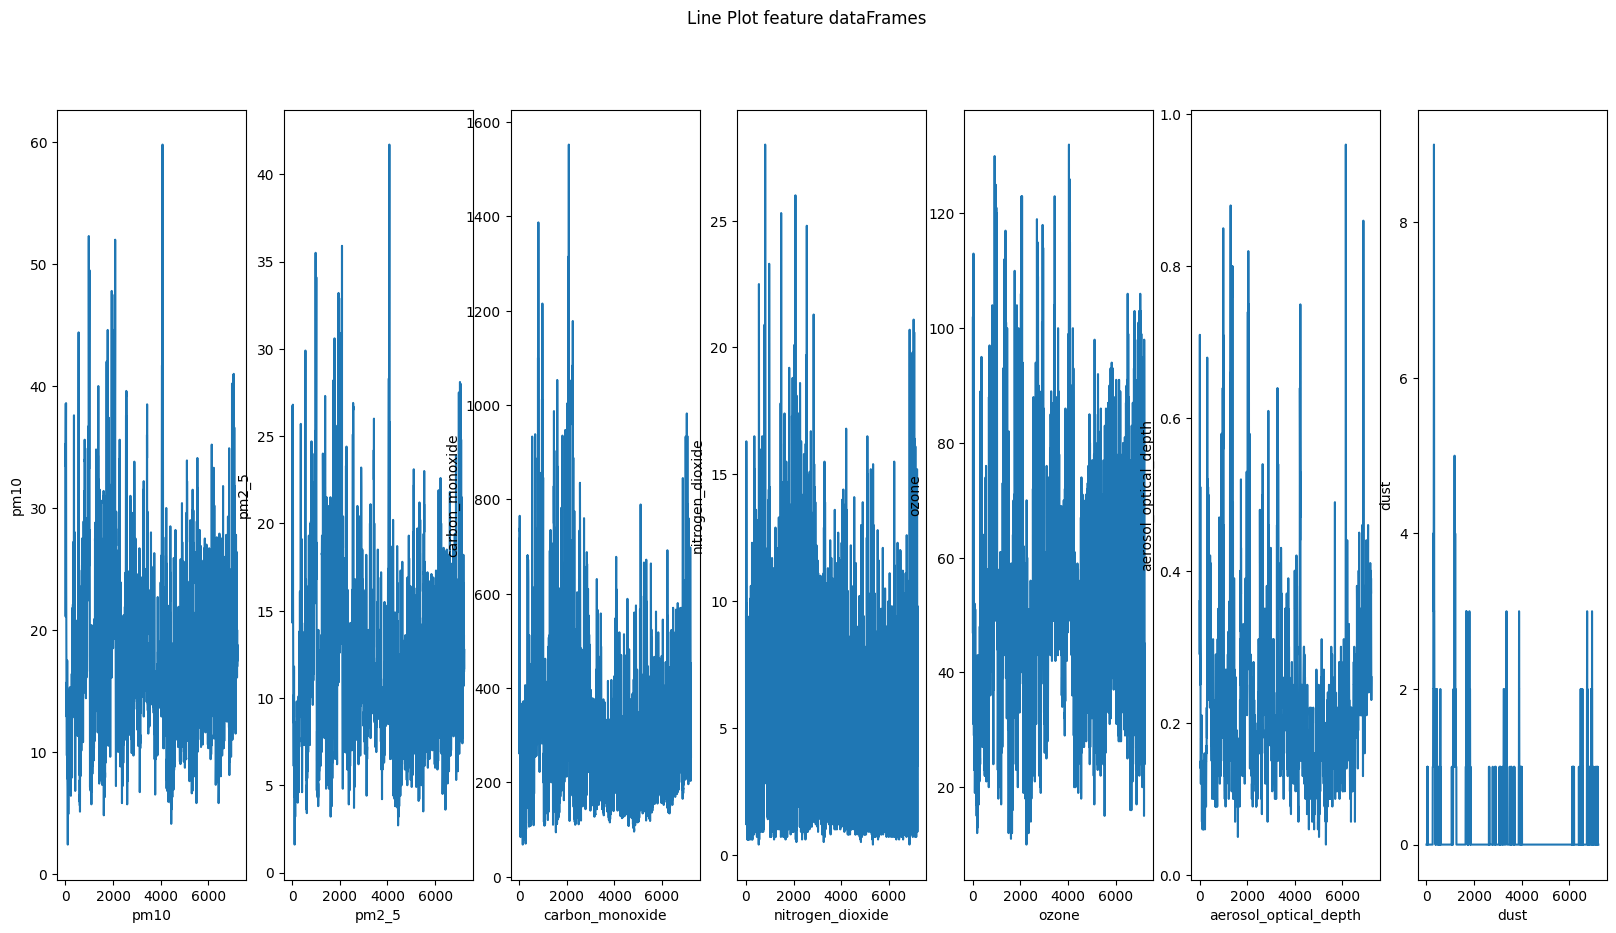

In [4]:
lineplot_features(data.iloc[:,1:],size=(20,10))

### Resample Line Plot

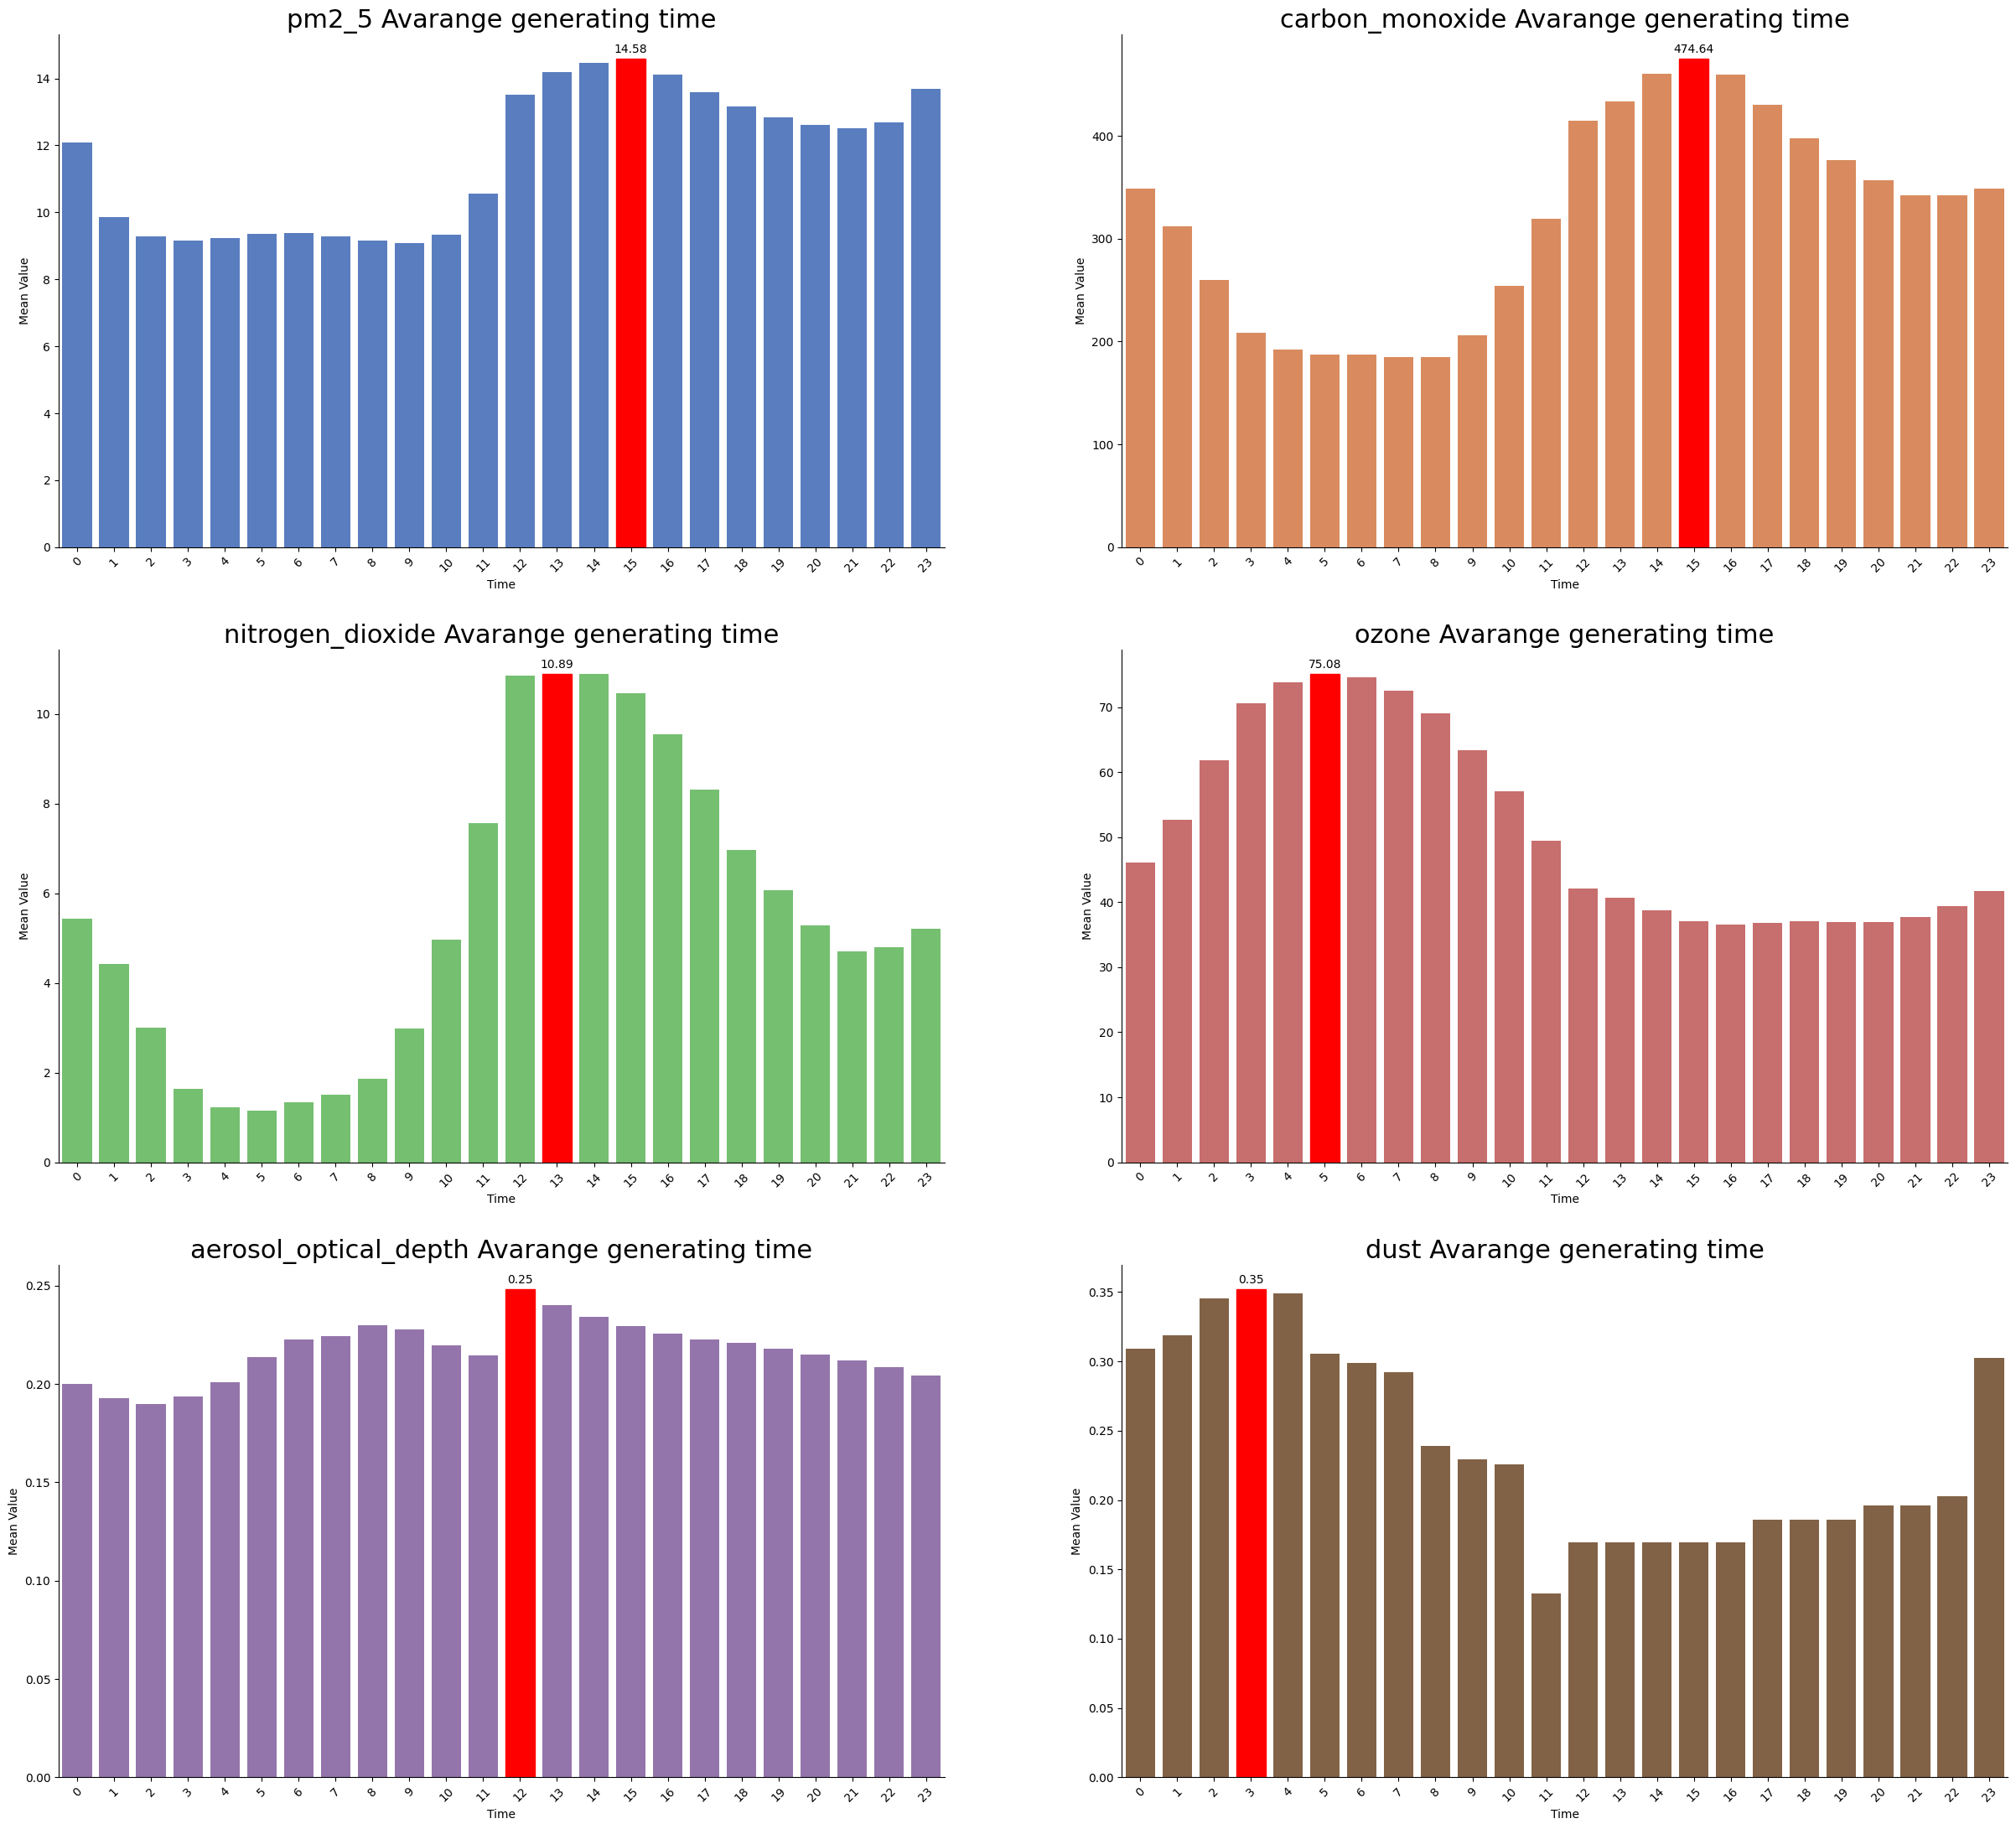

In [5]:
average_generating_barplot(data,on_feat="time")

### Linear Resample feature

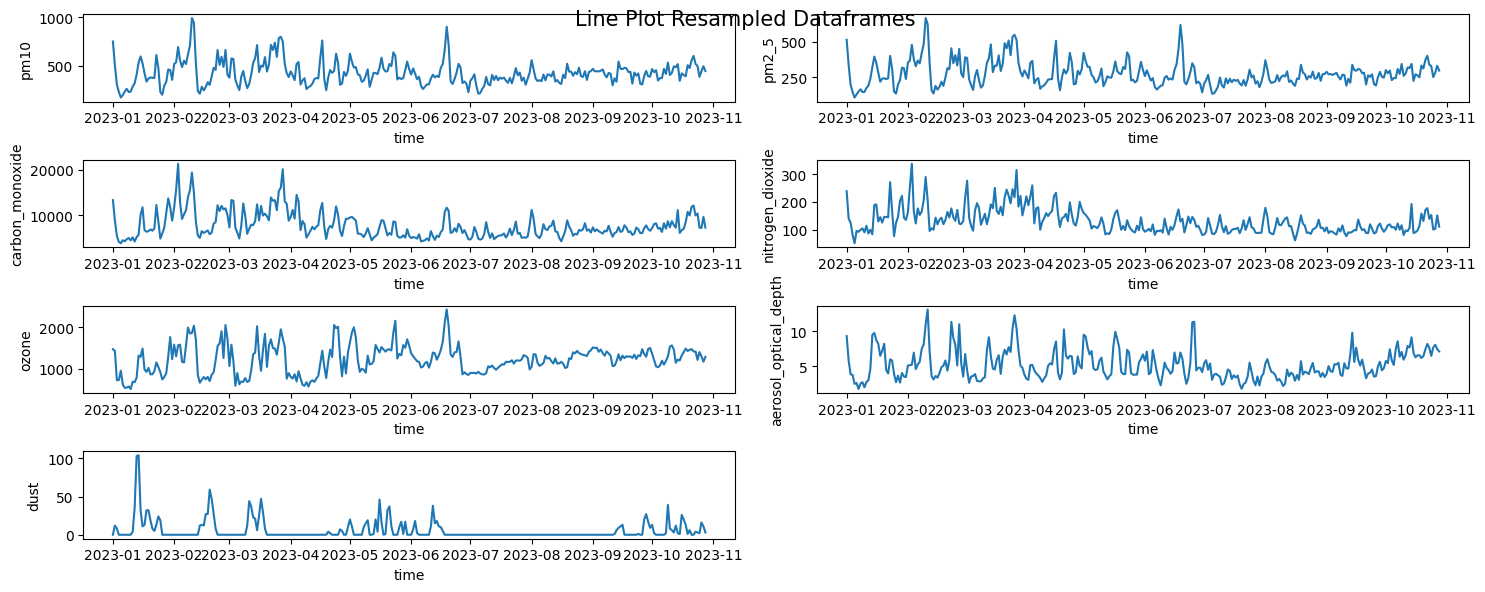

In [6]:
lineplot_resample_feature(data,"time","1D")

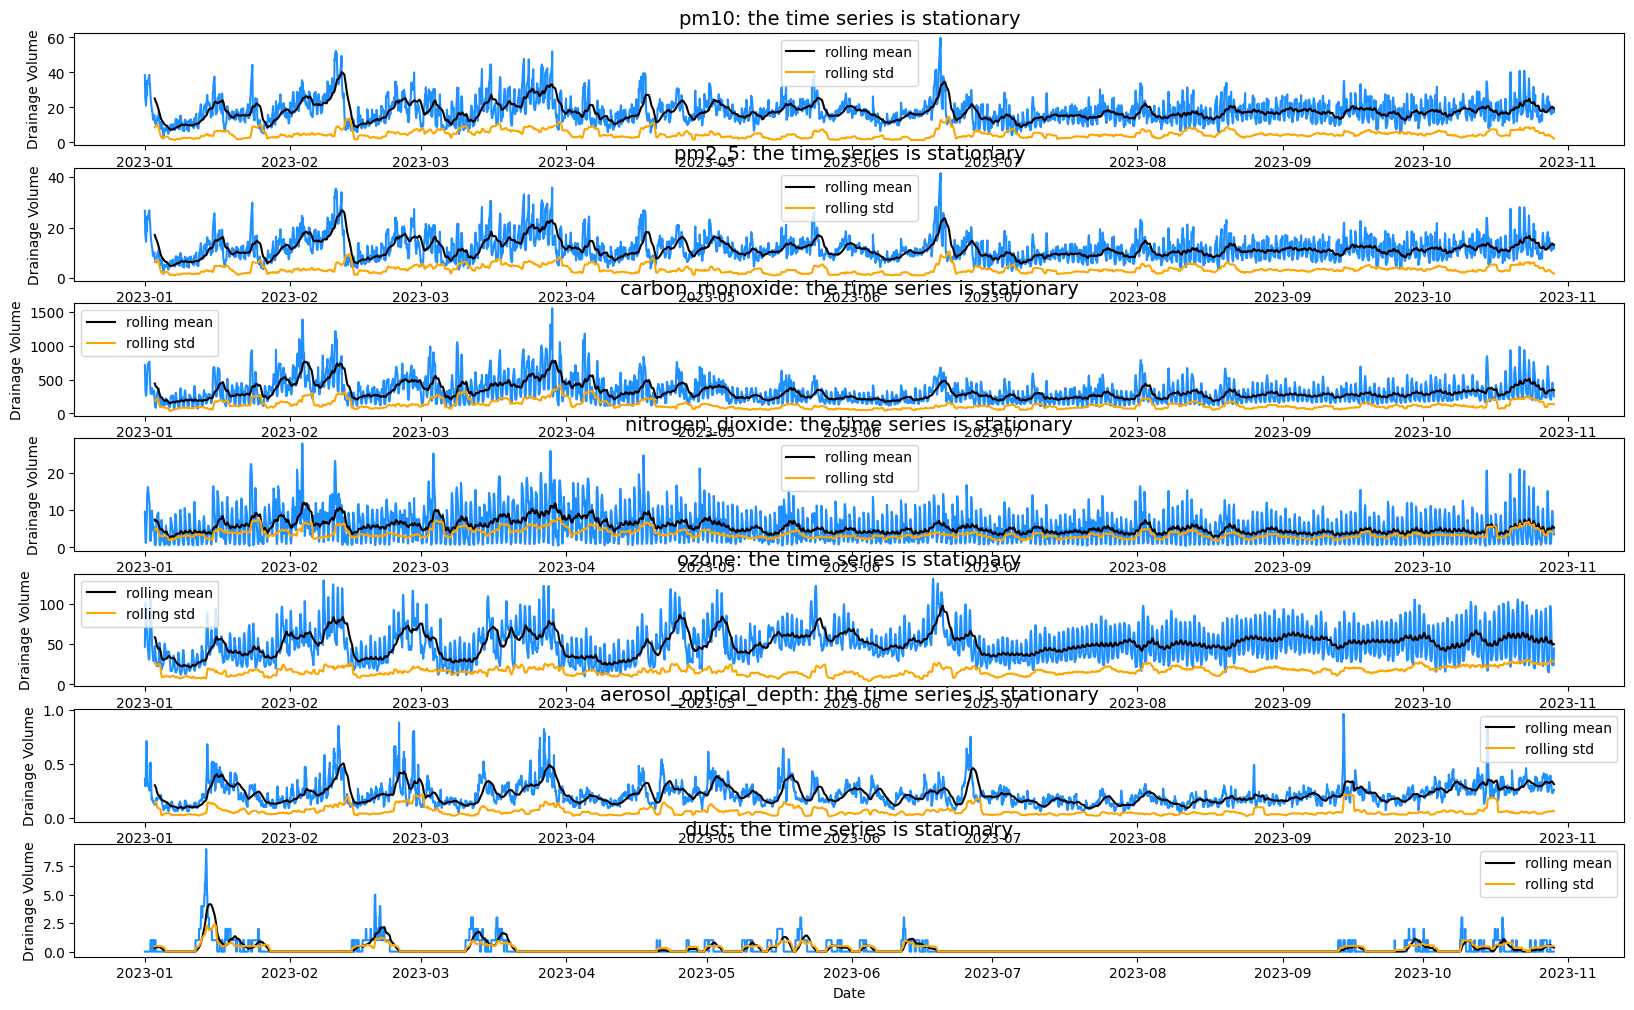

In [7]:
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pandas as pd

def plot_rolling_statistics(df: pd.DataFrame, rolling_window=7):
    """
    Plot rolling statistics for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        rolling_window (int, optional): Rolling window size for mean and std calculations. Defaults to 7.

    Returns:
        None: This function displays the plot but doesn't return any value.
    """
    numerical_features = df.select_dtypes(include=np.number).columns
    f, ax = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(20, 12))
    
    for i, feat in enumerate(numerical_features):
        sns.lineplot(x=df['time'], y=df[feat], ax=ax[i], color='dodgerblue')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).mean(), ax=ax[i], color='black', label='rolling mean')
        sns.lineplot(x=df['time'], y=df[feat].rolling(rolling_window).std(), ax=ax[i], color='orange', label='rolling std')
        
        # Calculate ADF test results
        adf_result = adfuller(df[feat], autolag="AIC")
        if adf_result[1] <= 0.05:
            ax[i].set_title(f'{feat}: the time series is stationary', fontsize=14)
        else:
            ax[i].set_title(f'{feat}: the time series is non-stationary', fontsize=14)

        # Add labels and legend
        ax[i].set_xlabel('Date')
        ax[i].set_ylabel('Drainage Volume')
        ax[i].legend()

    # Show the plot
    plt.show()

# Example usage:
plot_rolling_statistics(data,52)

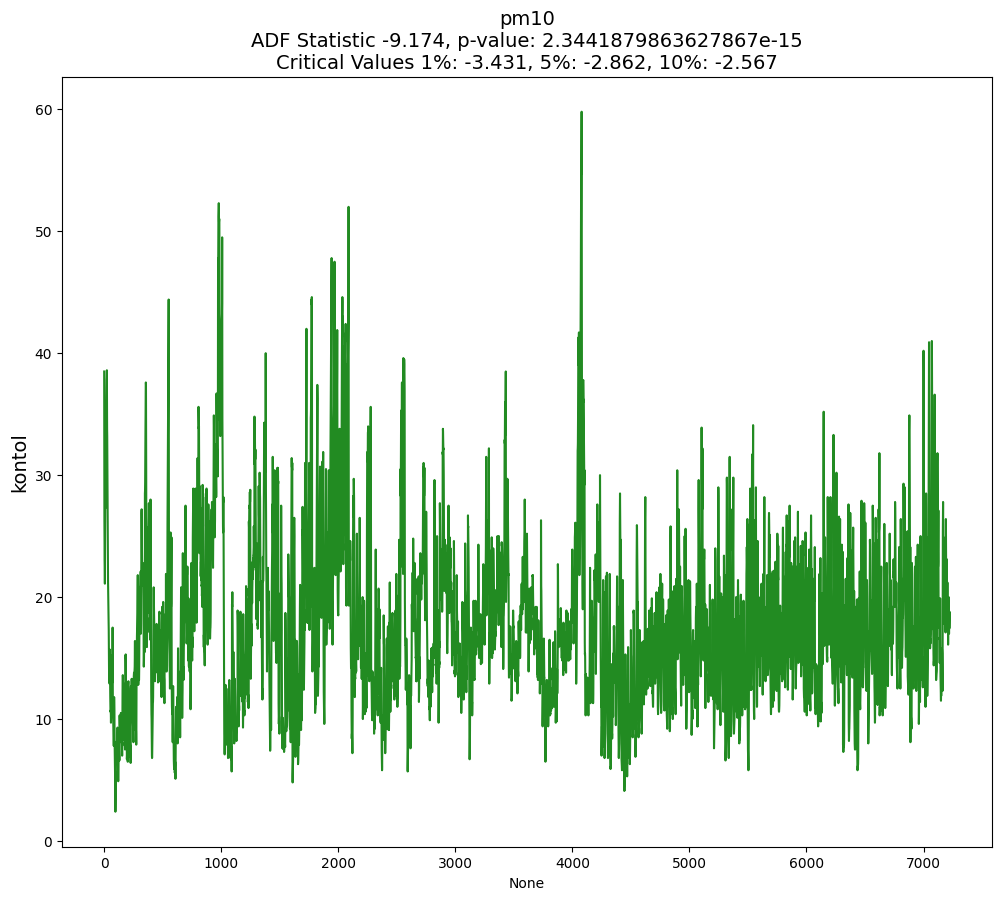

In [8]:
visualize_adfuller_results(data,"pm10","kontol")

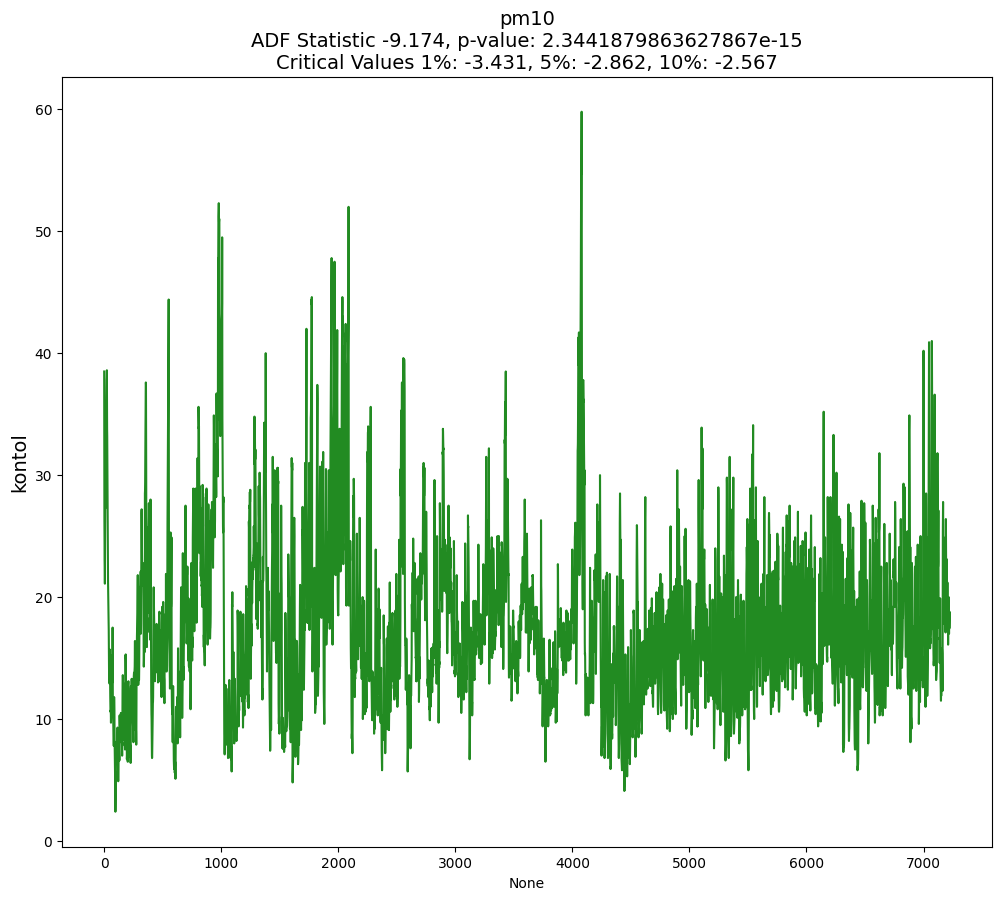

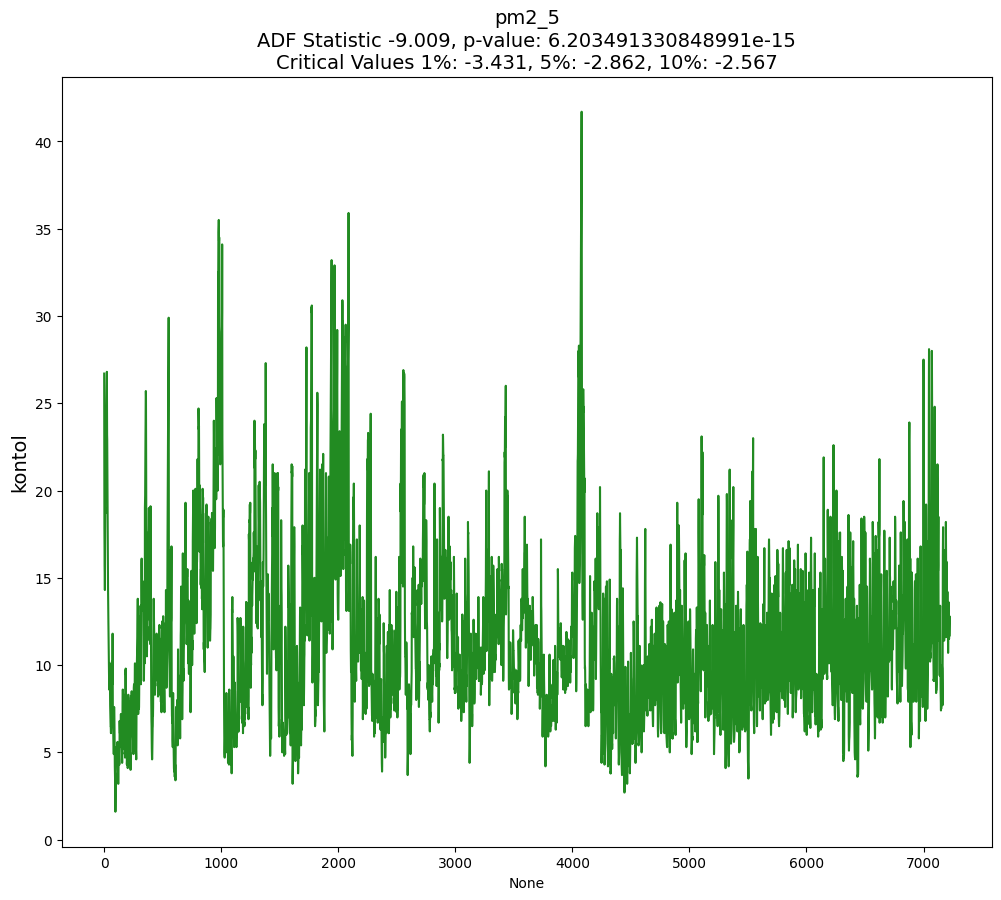

In [9]:
visualize_adfuller_results(data,["pm10","pm2_5"],"kontol")

## Data Preprocessing

#### - For Clustering Model

In [10]:
data_cluster = data.set_index("time").resample("D").mean()
data_cluster.reset_index(inplace=True)
# droping `time` feature
data_cluster.drop(["time","dust"],axis=1,inplace=True)
data_cluster.head()

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth
0,31.179167,21.466667,554.750000,9.929167,61.458333,0.387083
1,20.875000,14.025000,365.791667,5.804167,59.625000,0.241667
2,12.716667,8.241667,226.166667,5.237500,30.375000,0.160000
3,9.516667,6.112500,169.750000,3.404167,30.541667,0.156667
4,7.116667,4.491667,157.416667,2.137500,39.958333,0.103333


In [11]:
no_outliers_count = 0

for feat in data_cluster.columns:
    outlier = detect_outlier_zscore(data_cluster[feat])
    if any(outlier[0]):
        print(f"Outlier of {feat} is in index: {outlier[0]}")
        data_cluster[feat] = detect_outlier_zscore(data_cluster[feat], change_outlier=True)
    else:
        no_outliers_count += 1

if no_outliers_count == len(data_cluster.columns):
    print("No outliers found in any feature. Stopping iteration.")


Outlier of pm10 is in index: [ 40  41 169]
Outlier of pm2_5 is in index: [ 40  41  85 169]
Outlier of carbon_monoxide is in index: [33 40 86]
Outlier of nitrogen_dioxide is in index: [22 33 40 61 86]
Outlier of ozone is in index: [169]
Outlier of aerosol_optical_depth is in index: [41 85]


### Scaling Data

In [12]:
from sklearn.preprocessing import StandardScaler
pre_data = StandardScaler().fit_transform(data_cluster)

#### Modeling Data

In [13]:
from Tengai.model import dbscan_grid_search
_,_,_,best_parameter=dbscan_grid_search(pre_data)
best_parameter

(0.7000000000000001, 3)

In [14]:
from sklearn.cluster import DBSCAN,KMeans
cluster = DBSCAN(eps=best_parameter[0],min_samples=best_parameter[1])
best_clusters = cluster.fit_predict(X=pre_data)

The best number of clusters is: 6
Cluster Assignments:
Noise points: 89
Cluster 0: 194 data points
Cluster 1: 3 data points
Cluster 2: 6 data points
Cluster 3: 3 data points
Cluster 4: 3 data points
Cluster 5: 3 data points


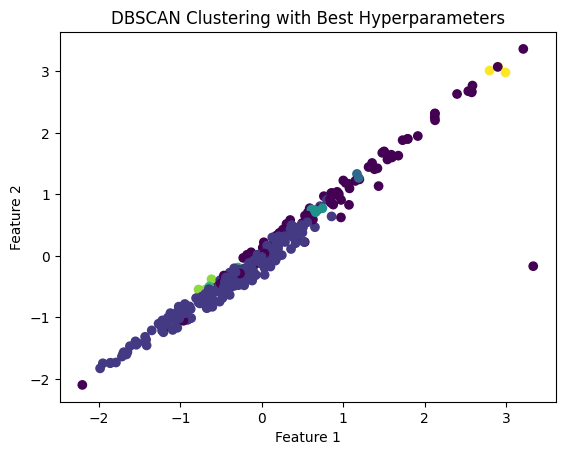

In [15]:
best_n_clusters = len(np.unique(best_clusters)) - 1
print(f"The best number of clusters is: {best_n_clusters}")

# Example: Print cluster assignments
print("Cluster Assignments:")
for label in np.unique(best_clusters):
    if label == -1:
        print(f"Noise points: {np.sum(best_clusters == label)}")
    else:
        print(f"Cluster {label}: {np.sum(best_clusters == label)} data points")

# Example: Visualize the clusters (you may use a suitable visualization library)
# This depends on the structure of your data and how you want to visualize it.
# For example, you can create a scatter plot using Matplotlib or Seaborn.
# Here's a basic example using Matplotlib:
import matplotlib.pyplot as plt
plt.scatter(pre_data[:, 0], pre_data[:, 1], c=best_clusters)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering with Best Hyperparameters')
plt.show()

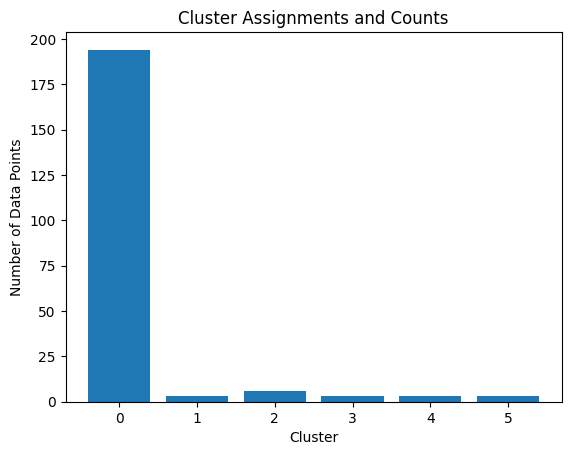

In [16]:
unique_clusters, cluster_counts = np.unique(best_clusters, return_counts=True)
unique_clusters = unique_clusters[1:]
cluster_counts = cluster_counts[1:]
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Assignments and Counts')
plt.show()

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


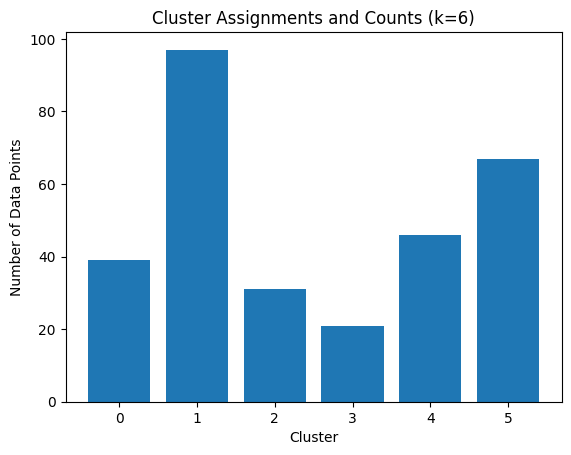

In [17]:
kmeans = KMeans(n_clusters=6,random_state=42,init="random",max_iter=100)
cluster_assignments = kmeans.fit_predict(pre_data)

# Count the number of data points in each cluster
unique_clusters, cluster_counts = np.unique(cluster_assignments, return_counts=True)

# Create a bar plot
plt.bar(unique_clusters, cluster_counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title(f'Cluster Assignments and Counts (k={6})')
plt.show()

In [18]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
# Evaluate K-Means clustering using Silhouette Score and Davies-Bouldin Index
kmeans_silhouette = silhouette_score(pre_data, cluster_assignments)
kmeans_db_index = davies_bouldin_score(pre_data, cluster_assignments)

# Evaluate DBSCAN clustering using Silhouette Score and Davies-Bouldin Index
dbscan_silhouette = silhouette_score(pre_data, best_clusters)
dbscan_db_index = davies_bouldin_score(pre_data, best_clusters)


In [19]:
print(f'K-Means Silhouette Score: {kmeans_silhouette}')
print(f'K-Means Davies-Bouldin Index: {kmeans_db_index}')
print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
print(f'DBSCAN Davies-Bouldin Index: {dbscan_db_index}')

K-Means Silhouette Score: 0.25848041924005105
K-Means Davies-Bouldin Index: 1.2345321208398456
DBSCAN Silhouette Score: 0.018916439120754247
DBSCAN Davies-Bouldin Index: 3.0094452894441757


In [20]:
import joblib
with open("cluster_mode.pkl","wb") as f:
    joblib.dump(kmeans,f)

In [21]:
load_cluster = joblib.load("cluster_mode.pkl")

In [22]:
with open("cluster_mode.pkl", "rb") as f:
    cluster_assignments = joblib.load(f)

In [23]:
cluster_assignments = cluster_assignments.predict(pre_data)

In [24]:
cluster_assignments

array([2, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 5, 2, 2, 5, 0, 5, 5, 0, 0,
       2, 0, 4, 4, 0, 0, 2, 5, 0, 2, 2, 3, 2, 5, 2, 2, 3, 2, 5, 2, 5, 4,
       4, 4, 4, 4, 0, 4, 0, 0, 5, 3, 3, 3, 2, 3, 5, 0, 2, 2, 0, 4, 4, 0,
       0, 0, 4, 4, 0, 5, 3, 3, 0, 2, 5, 3, 0, 5, 2, 2, 2, 2, 2, 2, 3, 2,
       0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 4, 4, 4, 0, 0, 0, 0, 2, 2, 0, 4, 0,
       5, 5, 5, 3, 3, 1, 4, 5, 0, 0, 3, 3, 3, 5, 5, 1, 1, 1, 1, 5, 4, 1,
       1, 1, 1, 5, 3, 5, 5, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 5, 5, 1, 5, 1,
       1, 5, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 5, 5, 3, 5, 3, 1, 1, 1, 5, 3,
       5, 4, 1, 4, 4, 4, 1, 0, 4, 4, 4, 4, 4, 0, 4, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 0, 2, 5, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 5, 5, 5, 5, 5, 5, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 1, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5]

In [25]:
label = {"good","fair","moderator","poor","very poor","Extremely poor"}
zipping = dict(zip(np.unique(kmeans.labels_),label))

In [26]:
import json
data_to_write = {str(key): value for key, value in zipping.items()}
with open("label_cluster.json","w") as f:
    json.dump(data_to_write,f)


In [27]:
with open('label_cluster.json', 'r') as file:
    # Load JSON data from the file
    label = json.load(file)

# Time Series Data preprocessing

In [28]:
times_series_df = data.set_index("time")
times_series_df = times_series_df.resample("D").mean().round(3)
times_series_df.reset_index(inplace=True)

In [29]:
times_series_df

,time,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
0,2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
1,2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2,2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
3,2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
4,2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000
...,...,...,...,...,...,...,...,...
296,2023-10-24,20.621,13.704,431.542,6.367,50.708,0.270,0.125
297,2023-10-25,15.987,10.500,300.667,4.192,58.542,0.320,0.083
298,2023-10-26,18.442,11.796,297.833,4.292,54.208,0.335,0.667
299,2023-10-27,20.562,13.821,400.667,6.312,48.917,0.310,0.458


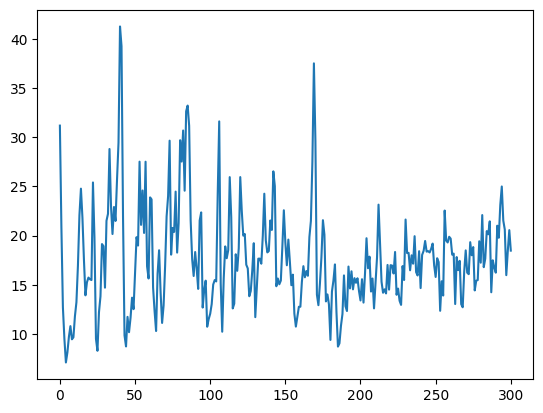

In [30]:
plt.plot(times_series_df["pm10"])

In [31]:
# check outlier
features = times_series_df.select_dtypes(include=np.number).columns
for feat in features:
    outliers = detect_outlier_zscore(times_series_df[feat])
    print(f"Outliers in {feat} are at indices: {outliers[0]}")

Outliers in pm10 are at indices: [ 40  41 169]
Outliers in pm2_5 are at indices: [ 40  41  85 169]
Outliers in carbon_monoxide are at indices: [33 40 86]
Outliers in nitrogen_dioxide are at indices: [22 33 40 61 86]
Outliers in ozone are at indices: [169]
Outliers in aerosol_optical_depth are at indices: [41 85]
Outliers in dust are at indices: [ 12  13  49  50  75 135]


In [32]:
# setting `time` feature be index
times_series_df.set_index("time",inplace=True)
times_series_df

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,aerosol_optical_depth,dust
time,,,,,,,
2023-01-01,31.179,21.467,554.750,9.929,61.458,0.387,0.000
2023-01-02,20.875,14.025,365.792,5.804,59.625,0.242,0.500
2023-01-03,12.717,8.242,226.167,5.238,30.375,0.160,0.333
2023-01-04,9.517,6.112,169.750,3.404,30.542,0.157,0.000
2023-01-05,7.117,4.492,157.417,2.138,39.958,0.103,0.000
...,...,...,...,...,...,...,...
2023-10-24,20.621,13.704,431.542,6.367,50.708,0.270,0.125
2023-10-25,15.987,10.500,300.667,4.192,58.542,0.320,0.083
2023-10-26,18.442,11.796,297.833,4.292,54.208,0.335,0.667


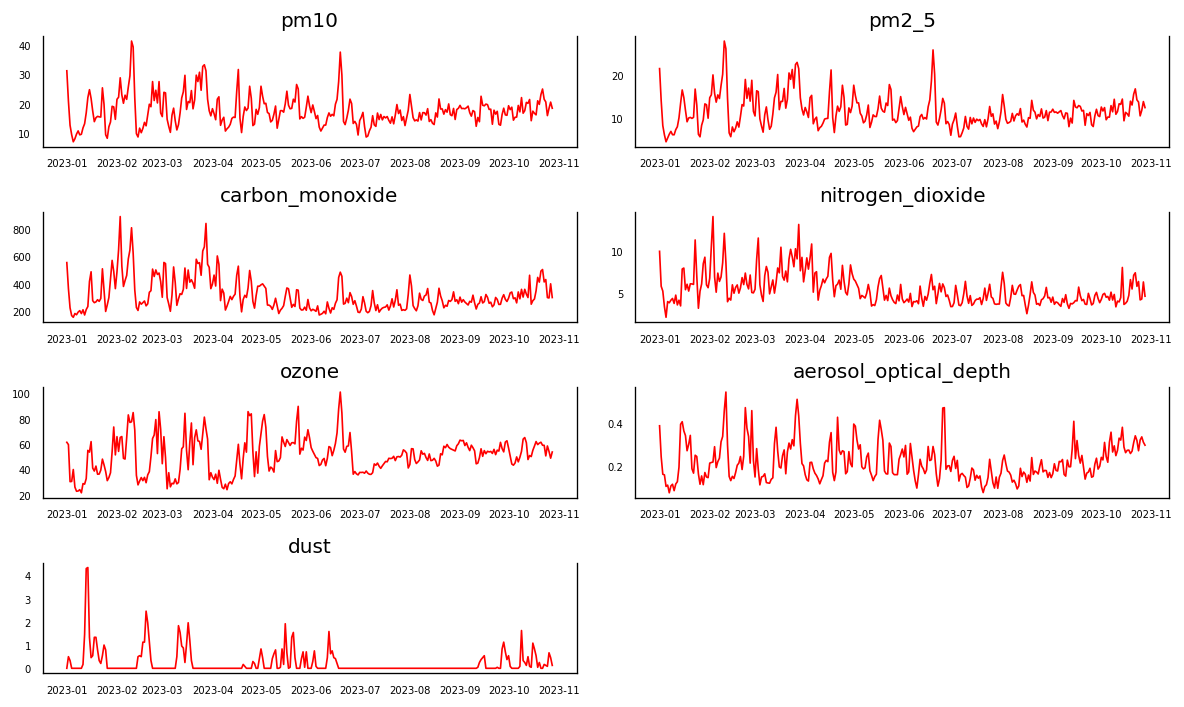

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(times_series_df.columns):
        data = times_series_df[times_series_df.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(times_series_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    else:
        # Jika ada subplot yang tersisa, hilangkan sumbunya.
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [34]:
grangers_causation_matrix(data=times_series_df, variables = times_series_df.columns)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  

,pm10_x,pm2_5_x,carbon_monoxide_x,nitrogen_dioxide_x,ozone_x,aerosol_optical_depth_x,dust_x
pm10_y,0.0000,0.3106,0.2021,0.0926,0.0261,0.0448,0.0342
pm2_5_y,0.1757,0.0000,0.1540,0.0717,0.0472,0.0568,0.0260
carbon_monoxide_y,0.0124,0.0120,0.0000,0.0001,0.0015,0.0222,0.1430
nitrogen_dioxide_y,0.0145,0.0096,0.0033,0.0000,0.1012,0.0051,0.1155
ozone_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0201,0.0106
aerosol_optical_depth_y,0.0441,0.0295,0.0210,0.0139,0.4136,0.0000,0.0005
dust_y,0.0172,0.0228,0.1018,0.5096,0.0164,0.0442,0.0000


from this,not all feature have relation with other feature
<br>

we want plotting different

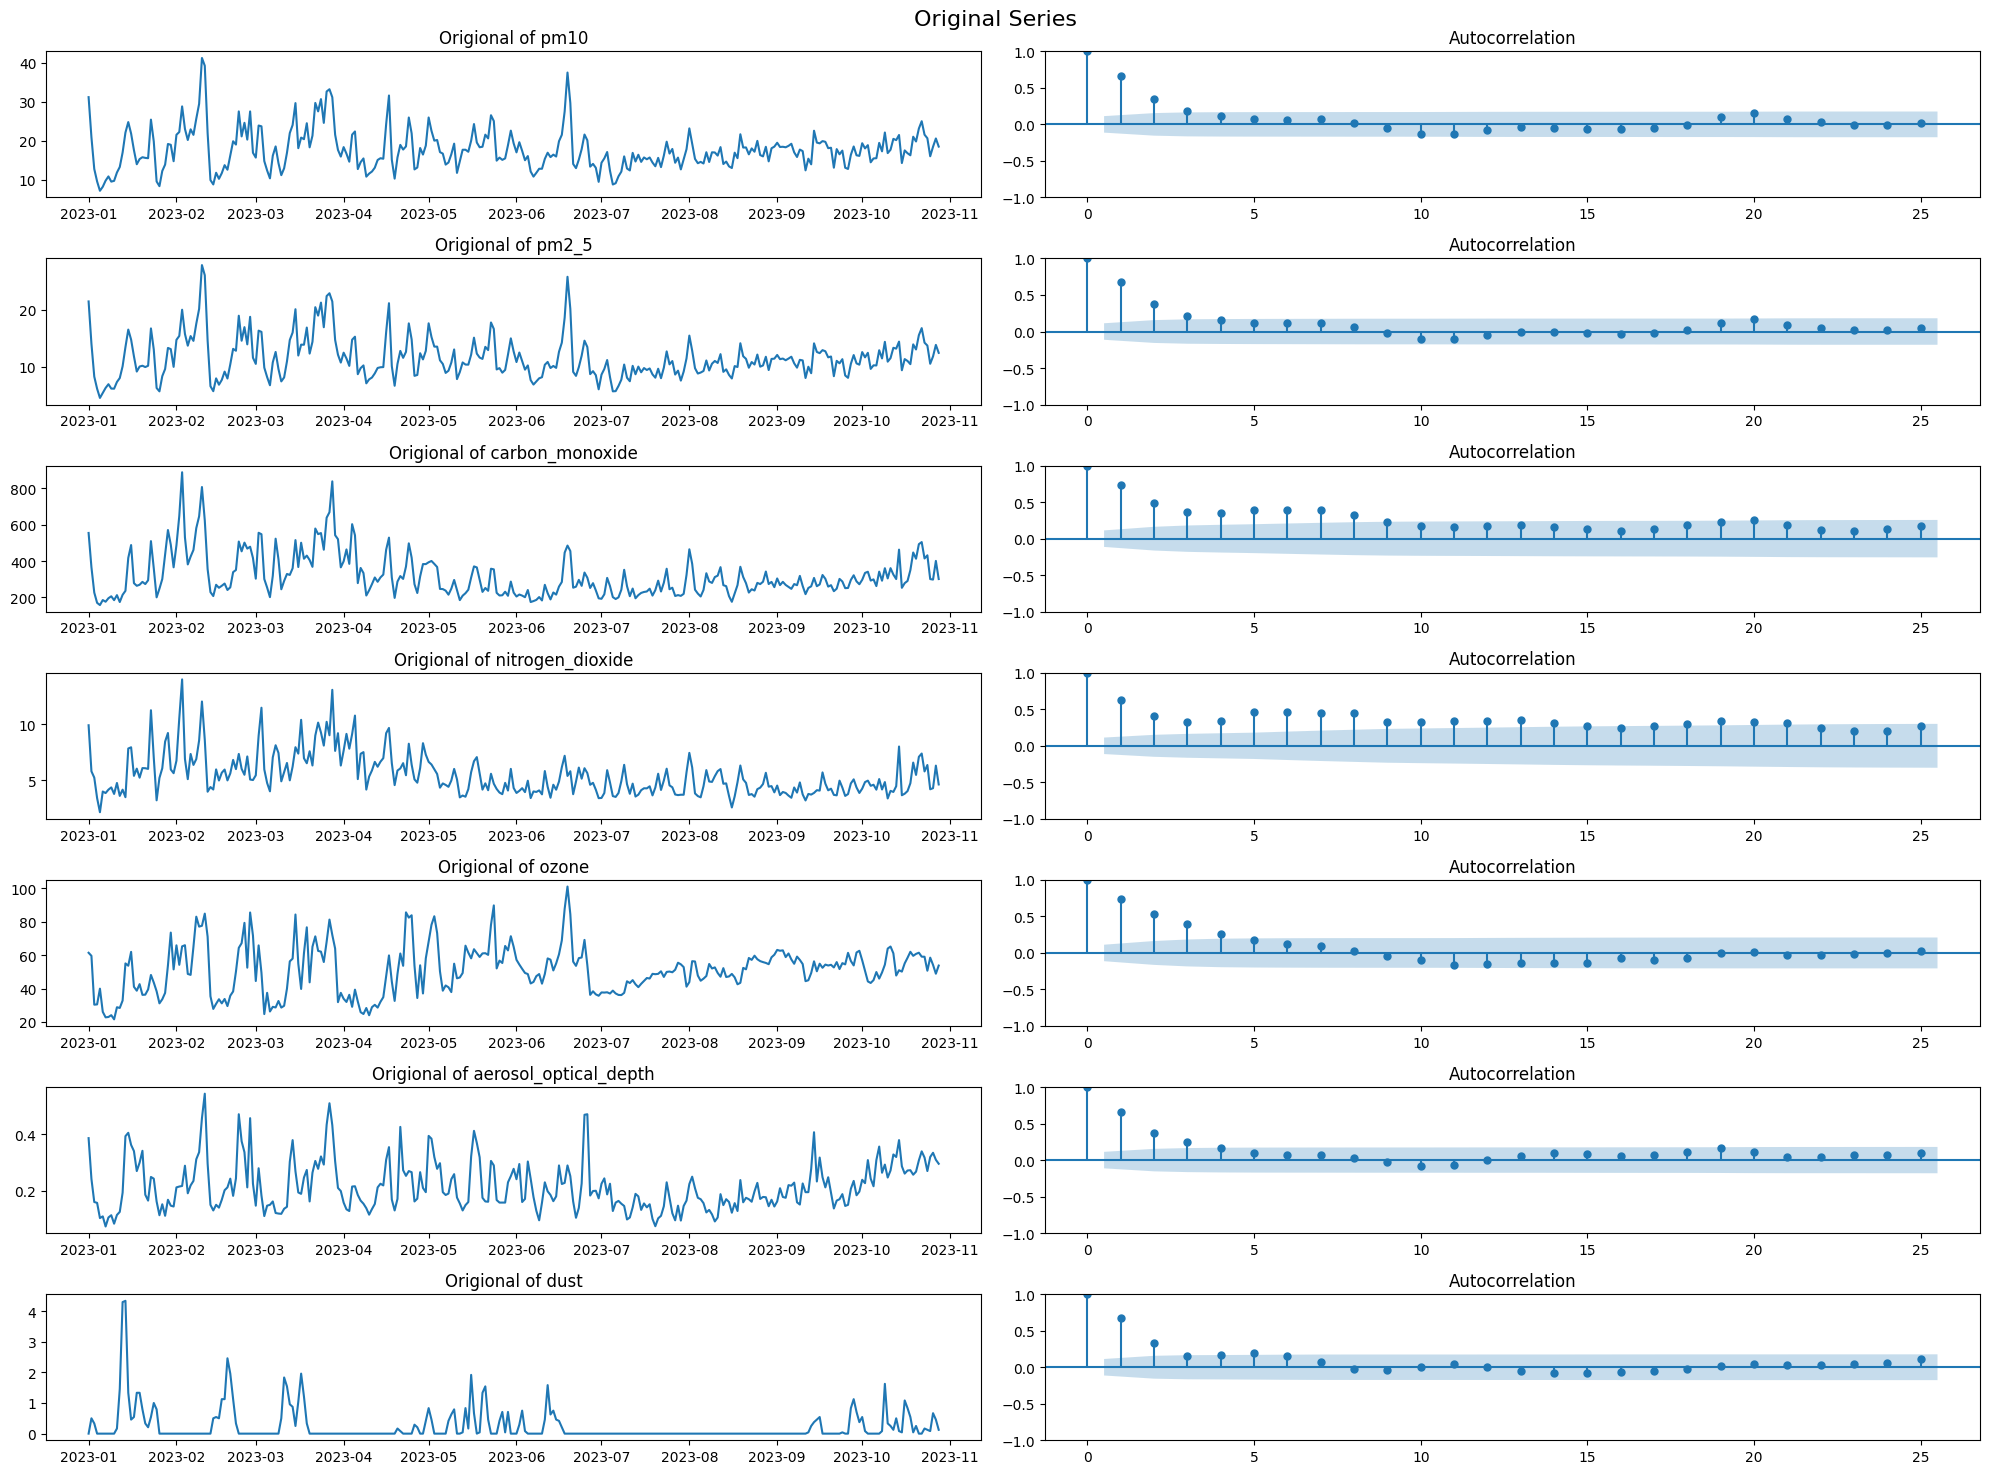

In [35]:
plotting_different(times_series_df,size=(20,15),
                   title="Original Series")

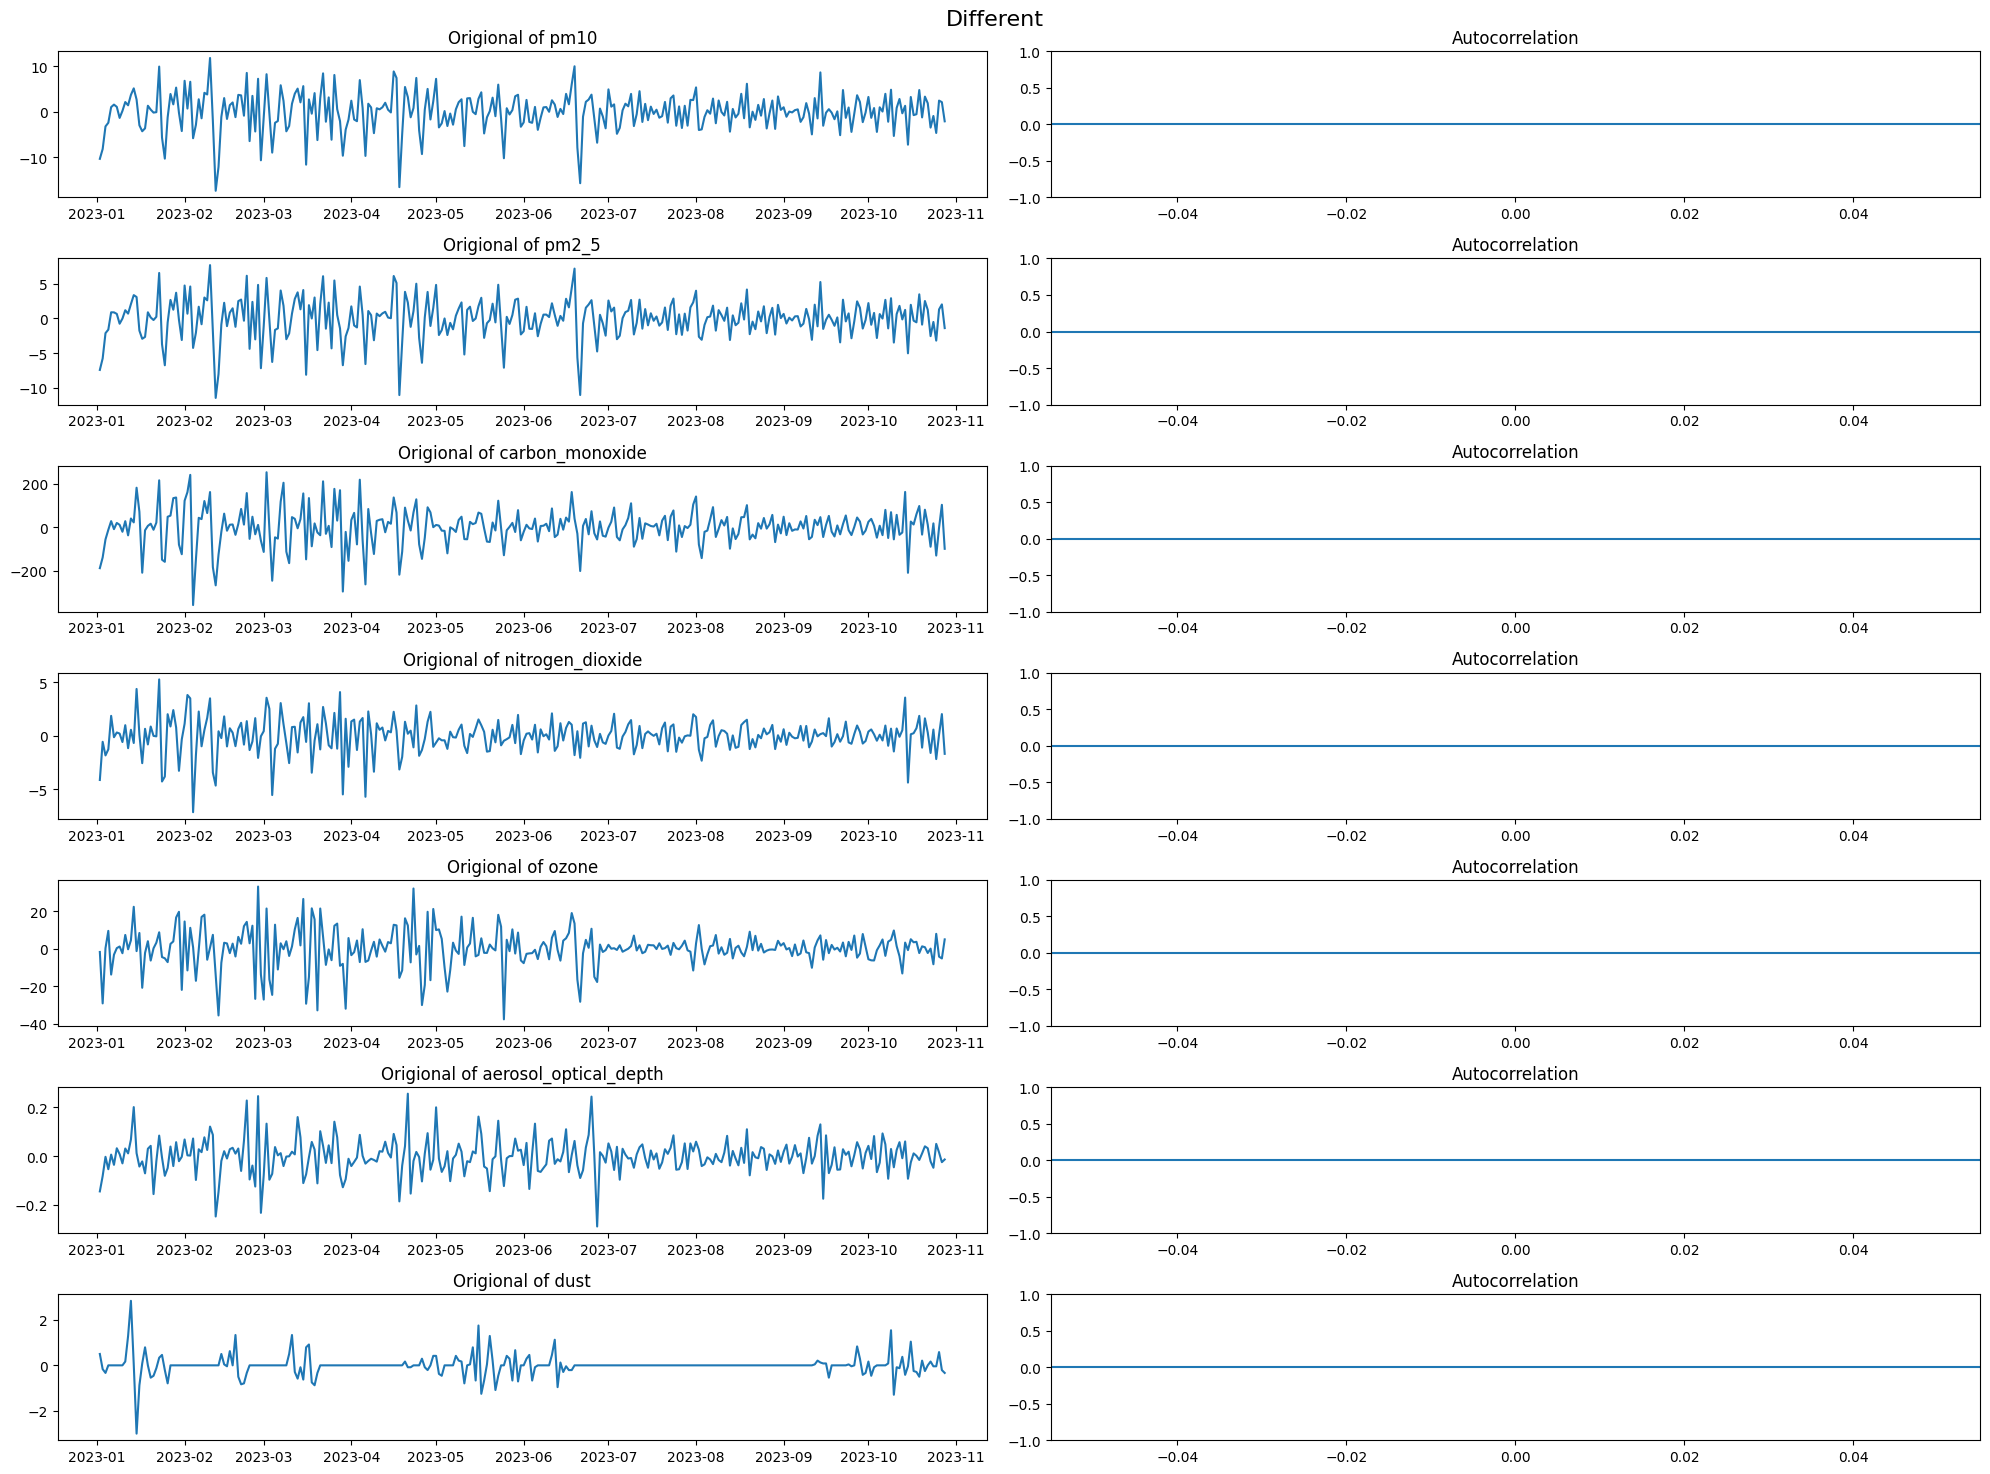

In [36]:
plotting_different(times_series_df.diff(),size=(20,15),
                   title="Different")

In [37]:
best_result = {}
for col in times_series_df.columns:
    result = detect_pdq_different(times_series_df[col])
    best_result[col] = result
print(best_result)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\s

{'pm10': {'Best AIC': 1677.2242595419953, 'Best BIC': 1695.7264774089488, 'Best p': 2, 'Best q': 2, 'Best d': 0}, 'pm2_5': {'Best AIC': 1454.8052608110238, 'Best BIC': 1473.3074786779773, 'Best p': 2, 'Best q': 2, 'Best d': 0}, 'carbon_monoxide': {'Best AIC': 3479.5714663207955, 'Best BIC': 3505.47457133453, 'Best p': 3, 'Best q': 3, 'Best d': 0}, 'nitrogen_dioxide': {'Best AIC': 1064.4264882118146, 'Best BIC': 1079.2282625053774, 'Best p': 0, 'Best q': 3, 'Best d': 0}, 'ozone': {'Best AIC': 2222.8039109459037, 'Best BIC': 2241.306128812857, 'Best p': 1, 'Best q': 3, 'Best d': 0}, 'aerosol_optical_depth': {'Best AIC': -769.4038665744878, 'Best BIC': -750.9016487075344, 'Best p': 1, 'Best q': 3, 'Best d': 0}, 'dust': {'Best AIC': 300.67915985020676, 'Best BIC': 322.8818212905509, 'Best p': 3, 'Best q': 2, 'Best d': 0}}


c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
for col in times_series_df.columns:
    print(f"{col}\n {best_result[col]}")

pm10
 {'Best AIC': 1677.2242595419953, 'Best BIC': 1695.7264774089488, 'Best p': 2, 'Best q': 2, 'Best d': 0}
pm2_5
 {'Best AIC': 1454.8052608110238, 'Best BIC': 1473.3074786779773, 'Best p': 2, 'Best q': 2, 'Best d': 0}
carbon_monoxide
 {'Best AIC': 3479.5714663207955, 'Best BIC': 3505.47457133453, 'Best p': 3, 'Best q': 3, 'Best d': 0}
nitrogen_dioxide
 {'Best AIC': 1064.4264882118146, 'Best BIC': 1079.2282625053774, 'Best p': 0, 'Best q': 3, 'Best d': 0}
ozone
 {'Best AIC': 2222.8039109459037, 'Best BIC': 2241.306128812857, 'Best p': 1, 'Best q': 3, 'Best d': 0}
aerosol_optical_depth
 {'Best AIC': -769.4038665744878, 'Best BIC': -750.9016487075344, 'Best p': 1, 'Best q': 3, 'Best d': 0}
dust
 {'Best AIC': 300.67915985020676, 'Best BIC': 322.8818212905509, 'Best p': 3, 'Best q': 2, 'Best d': 0}


In [39]:
p_value = best_result["pm10"]["Best p"]
q_value = best_result["pm10"]["Best q"]
d_value = best_result["pm10"]["Best d"]
arima_model = ARITMA(1, 1, 0)
model_results = arima_model.fit_arima_model(times_series_df["pm10"])
model_results.summary()

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pm10   No. Observations:                  301
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -830.442
Date:                Sat, 28 Oct 2023   AIC                           1668.884
Time:                        20:18:13   BIC                           1683.712
Sample:                    01-01-2023   HQIC                          1674.818
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7983      0.724     24.572      0.000      16.379      19.218
ar.L1          0.5537      0.055     10.128      0.000       0.447       0.661
ma.L1          0.2252      0.066      3.387      0.001       0.095       0.355
sigma2        14.5541      0.959     15.180      0.000      12.675      16.433
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                38.53
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

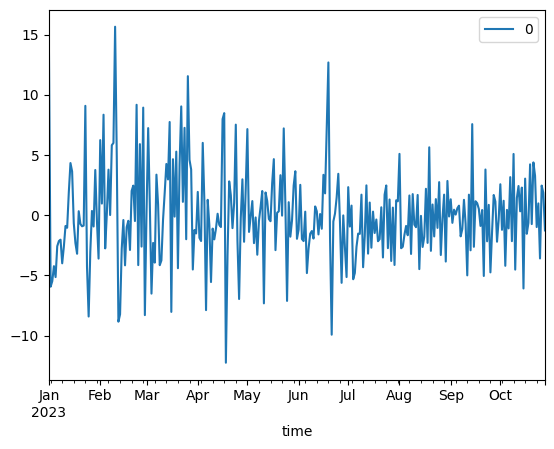

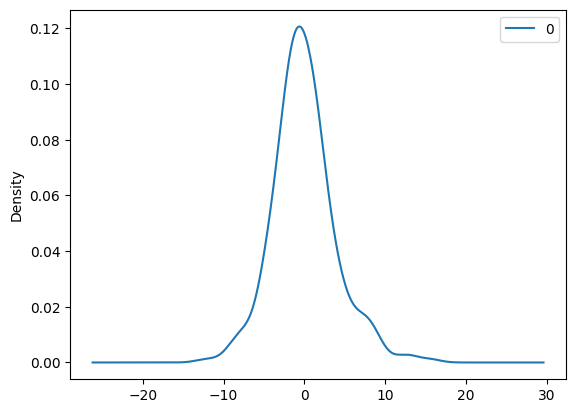

                0
count  301.000000
mean    -0.022786
std      3.857844
min    -12.252804
25%     -2.205235
50%     -0.361644
75%      1.809179
max     15.646862


In [40]:
residuals = pd.DataFrame(model_results.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [41]:
times_series_df["pm10"]

time
2023-01-01    31.179
2023-01-02    20.875
2023-01-03    12.717
2023-01-04     9.517
2023-01-05     7.117
               ...  
2023-10-24    20.621
2023-10-25    15.987
2023-10-26    18.442
2023-10-27    20.562
2023-10-28    18.479
Name: pm10, Length: 301, dtype: float64

In [42]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pm10   No. Observations:                  301
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -830.442
Date:                Sat, 28 Oct 2023   AIC                           1668.884
Time:                        20:18:13   BIC                           1683.712
Sample:                    01-01-2023   HQIC                          1674.818
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7983      0.724     24.572      0.000      16.379      19.218
ar.L1          0.5537      0.055     10.128      0.000       0.447       0.661
ma.L1          0.2252      0.066      3.387      0.001       0.095       0.355
sigma2        14.5541      0.959     15.180      0.000      12.675      16.433
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                38.53
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
result_predict = arima_model.forecast_arima_model(model_results,steps=6)

In [44]:
data = times_series_df["pm10"]
train_size = int(len(data) * 0.7)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
model = ARITMA(2,2,0)
model_results = model.fit_arima_model(train_data)
accuracy_score = model.accuracy_model(test_data)
print(model_results.summary())
print(accuracy_score)

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   pm10   No. Observations:                  210
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -599.858
Date:                Sat, 28 Oct 2023   AIC                           1211.716
Time:                        20:18:14   BIC                           1231.798
Sample:                    01-01-2023   HQIC                          1219.834
                         - 07-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8693      1.003     17.816      0.000      15.904      19.835
ar.L1         -0.0168      0.591     -0.028      0.977      -1.175       1.141
ar.L2          0.2194      0.375      0.585      0.5

c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\iqbal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


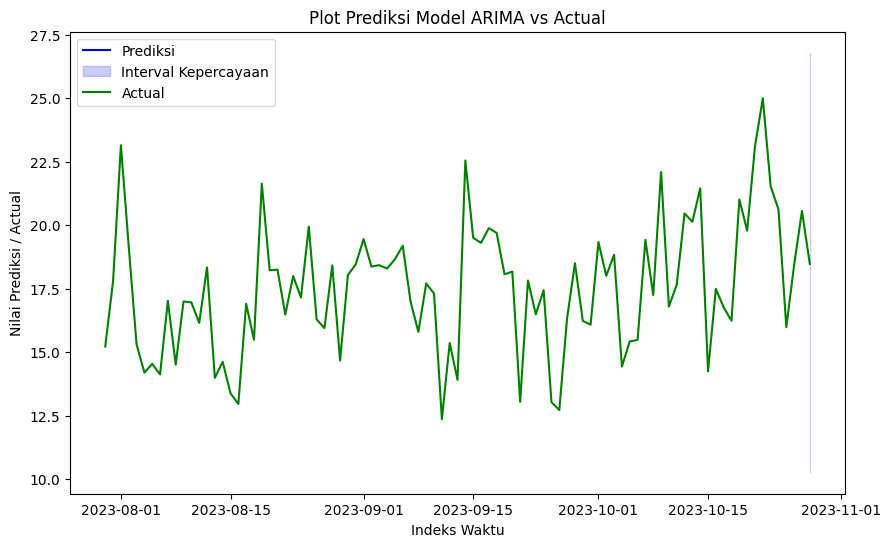

Mean Absolute Error (MAE): 2.1767707327532997
Mean Absolute Percentage Error (MAPE): 0.1344750165171327


In [49]:
# see data mya
data = times_series_df["pm10"]
train_size = int(len(data) * 0.7)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
# Fit an ARIMA model to your data
p_value = 1
q_value = 1
d_value = 0
model =ARITMA(p_value, d_value, q_value)
model_result = model.fit_arima_model(data)
model.plot_predict(model_result, test_data, steps=3)
accuracy = model.accuracy_model(test_data)
print("Mean Absolute Error (MAE):", accuracy["mae"])
print("Mean Absolute Percentage Error (MAPE):", accuracy["mape"])

# Reference

![VAR Forecasting](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/#google_vignette)

![Aritma Forecasting](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#google_vignette)